In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import datetime
from scipy.stats import linregress

# Import API key
from config import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
coordinates = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=10) # Change size to 1500 after testing
lngs = np.random.uniform(lng_range[0], lng_range[1], size=10) # Change size to 1500 after testing
coordinates = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for coord in coordinates:
    city = citipy.nearest_city(coord[0], coord[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

10

In [23]:
# Request weather data (temperature, humidity, cloudiness, windspeed) from OpenWeather

successful_cities = []
lat = []
lng = []
temp = []
humidity = []
cloudiness = []
windspeed = []
country = []
date = []

print("-----------------------------------")
print("Retrieving Data – Please be patient")
print("-----------------------------------")

for city in cities:
    
    # Avoid exceeding 60 calls per minute from API request
    time.sleep(1)
    
    # Request data from API
    city_url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={weather_api_key}&units=imperial"
    response = requests.get(city_url).json()
    
    try:
        lat.append(response["coord"]["lat"])
        lng.append(response["coord"]["lon"])
        temp.append(response["main"]["temp_max"])
        humidity.append(response["main"]["humidity"])
        cloudiness.append(response["clouds"]["all"])
        windspeed.append(response["wind"]["speed"])
        country.append(response["sys"]["country"])
        date.append(response["dt"])
        successful_cities.append(city)
        print(f"Found data for city #{len(successful_cities)}: {city}")
        
    except:
        print(f"City '{city}' not found. Proceeding to next city.")
        pass
    
print("-------------------------------------------")
print(f"Successfully retrieved data for {len(successful_cities)} cities.")
print("-------------------------------------------")

-----------------------------------
Retrieving Data – Please be patient
-----------------------------------
Found data for city #1: busselton
Found data for city #2: kavaratti
Found data for city #3: riyadh
Found data for city #4: bathsheba
Found data for city #5: elko
Found data for city #6: hilo
Found data for city #7: carmen
City 'longlac' not found. Proceeding to next city.
Found data for city #8: butaritari
Found data for city #9: jambi
-------------------------------------------
Successfully retrieved data for 9 cities.
-------------------------------------------


In [38]:
# Create a dataframe
weather_df = pd.DataFrame({
    "City":successful_cities,
    "Latitude":lat,
    "Longitude":lng,
    "Max Temperature (°F)":temp,
    "Humidity (%)":humidity,
    "Cloudiness (%)":cloudiness,
    "Wind Speed (mph)":windspeed,
    "Country Code":country,
    "Date & Time":date
})

# Extract average timestamp & store for later
mean_date = weather_df["Date & Time"].mean()
retrieval_date = datetime.datetime.fromtimestamp(mean_date).date()

# Export data into a csv
weather_df.to_csv(output_data_file,index = False)


weather_df.head()

,City,Latitude,Longitude,Max Temperature (°F),Humidity (%),Cloudiness (%),Wind Speed (mph),Country Code,Date & Time
0,busselton,-33.6500,115.3333,55.99,98,75,7.40,AU,1612810595
1,kavaratti,10.5669,72.6420,81.61,66,0,7.61,IN,1612810596
2,riyadh,24.6877,46.7219,60.80,51,0,8.05,SA,1612810442
3,bathsheba,13.2167,-59.5167,82.40,57,20,19.57,BB,1612810598
4,elko,41.0002,-115.5012,50.00,14,1,13.80,US,1612810599


## Scatterplots

This scatterplot shows the relationship between Temperature and Latitude of each city.

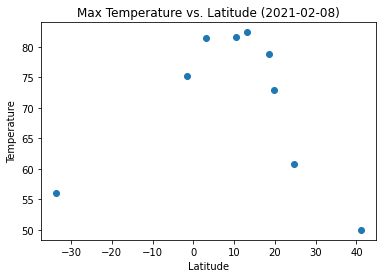

In [46]:
plt.scatter(weather_df["Latitude"],weather_df["Max Temperature (°F)"])
plt.title(f'Max Temperature vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel("Temperature")
plt.savefig("output_data/Temperature_vs_Latitude.png")
plt.show()

This scatterplot shows the relationship between Humidity and Latitude of each city.

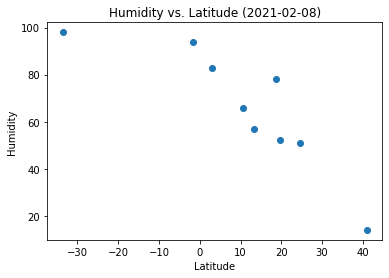

In [40]:
plt.scatter(weather_df["Latitude"],weather_df["Humidity (%)"])
plt.title(f'Humidity vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.savefig("output_data/Humidity_vs_Latitude.png")
plt.show()

This scatterplot shows the relationship between Cloudiness and Latitude of each city.

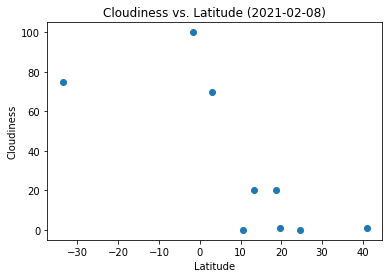

In [41]:
plt.scatter(weather_df["Latitude"],weather_df["Cloudiness (%)"])
plt.title(f'Cloudiness vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.savefig("output_data/Cloudiness_vs_Latitude.png")
plt.show()

This scatterplot shows the relationship between Wind Speed and Latitude of each city.

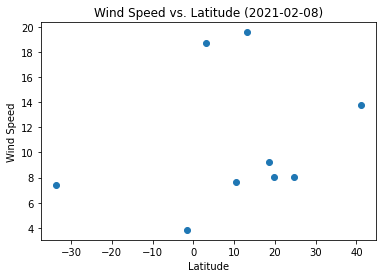

In [42]:
plt.scatter(weather_df["Latitude"],weather_df["Wind Speed (mph)"])
plt.title(f'Wind Speed vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.savefig("output_data/Wind_Speed_vs_Latitude.png")
plt.show()

In [ ]:
# May need to drop humidity outliers (above 100%)